In [1]:
!pip uninstall langchain -Y
!pip install -q langchain==0.3.22 langchain-aws==0.2.18 langchain-community==0.3.20 langchain-core==0.3.49 langchain-experimental==0.3.4 langgraph


Usage:   
  pip uninstall [options] <package> ...
  pip uninstall [options] -r <requirements file> ...

no such option: -Y


In [2]:
!python --version

Python 3.12.9


In [3]:
from langchain.chat_models import init_chat_model
import pydantic


# Initialize BedrockChat model
llm = init_chat_model(
    "amazon.nova-pro-v1:0",
    model_provider="bedrock",
    model_kwargs={'temperature': 0.7}
)


In [4]:
import pandas as pd
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.tools import PythonAstREPLTool

df_azure = pd.read_csv("AzureUsage.csv")
df_aws = pd.read_csv("AWSUsage.csv")

tool = PythonAstREPLTool(locals={"df_azure": df_azure})
tool.invoke("df_azure['Cost'].mean()")

2.1642921072041164

In [5]:
df_azure.head()

,SubscriptionName,SubscriptionGuid,Date,ResourceGuid,ServiceName,ServiceType,ServiceRegion,ServiceResource,Quantity,Cost
0,BISTEC Care Azure Sponsorship 002,1d3baa58-d65d-4735-a333-dd5f4aa49125,3/30/2025,ce912ed9-61fb-4d64-ad8d-13018897497f,Storage,Tiered Block Blob,US West,LRS List and Create Container Operations,0.000100,0.000006
1,BISTEC Care Azure Sponsorship 002,1d3baa58-d65d-4735-a333-dd5f4aa49125,3/30/2025,32c3ebec-1646-49e3-8127-2cafbd3a04d8,Bandwidth,Rtn Preference: MGN,All,Standard Data Transfer In,0.000002,0.000000
2,BISTEC Care Azure Sponsorship 002,1d3baa58-d65d-4735-a333-dd5f4aa49125,11/22/2024,9cb72649-e2e7-54db-a00f-2f543e351e6b,Dataverse,All,Global,Database Capacity Data Stored,0.015001,0.720053
3,BISTEC Care Azure Sponsorship 002,1d3baa58-d65d-4735-a333-dd5f4aa49125,11/23/2024,9cb72649-e2e7-54db-a00f-2f543e351e6b,Dataverse,All,Global,Database Capacity Data Stored,0.004610,0.221303
4,BISTEC Care Azure Sponsorship 002,1d3baa58-d65d-4735-a333-dd5f4aa49125,11/24/2024,9cb72649-e2e7-54db-a00f-2f543e351e6b,Dataverse,All,Global,Database Capacity Data Stored,0.015284,0.733604


In [6]:
df_aws.head()

,Unnamed: 0,Services,Regions,Costs,Dates
0,0,RedShift,global,26.024175,2024-12-27
1,1,RedShift,west,48.582640,2024-12-07
2,2,S3,east,29.616186,2025-02-02
3,3,RedShift,global,51.251502,2025-02-23
4,4,SageMaker,east,48.601562,2024-12-16


In [7]:
from langchain_core.output_parsers.openai_tools import JsonOutputKeyToolsParser
llm_with_tools = llm.bind_tools([tool], tool_choice=tool.name)
parser = JsonOutputKeyToolsParser(key_name=tool.name, first_tool_only=True)
(llm_with_tools | parser).invoke(
    "I have a dataframe about Azure cloud usage and want to know the cost for each service region"
)

{'query': "import pandas as pd\n\n# Assuming the dataframe is named 'df' and has columns 'service_region' and 'cost'\ndf = pd.DataFrame({\n    'service_region': ['East US', 'West US', 'East US', 'West US', 'East US'],\n    'cost': [100, 200, 150, 250, 300]\n})\n\n# Group by 'service_region' and sum the 'cost'\ncost_by_region = df.groupby('service_region')['cost'].sum()\ncost_by_region"}

In [9]:

tool = PythonAstREPLTool(locals={"df_aws": df_aws, "df_azure": df_azure})
llm_with_tool = llm.bind_tools(tools=[tool], tool_choice=tool.name)
df_template = """\`\`\`python
{df_name}.head().to_markdown()
>>> {df_head}
\`\`\`"""
df_context = "\n\n".join(
    df_template.format(df_head=_df.head().to_markdown(), df_name=df_name)
    for _df, df_name in [(df_aws, "df_aws"), (df_azure, "df_azure")]
)

system = f"""You have access to two pandas dataframes. \
Here is a sample of rows from each dataframe and the python code that was used to generate the sample:

{df_context}

Given a user question about the dataframes, write the Python code to answer it. \
Don't assume you have access to any libraries other than built-in Python ones and pandas. \
Make sure to refer only to the variables mentioned above."""
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{question}")])

chain = prompt | llm_with_tool | parser | tool
chain.invoke(
    {
        "question": "What is the average cost of each of the AWS Services?"
    }
)

Services
RedShift     41.952767
S3           29.616200
SageMaker    48.601600
Name: Costs, dtype: float64

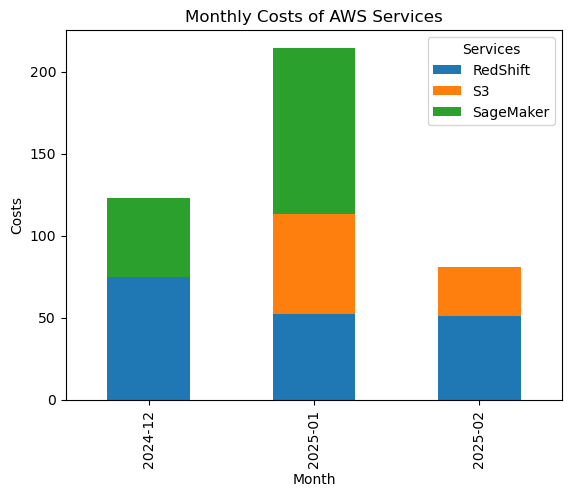

''

In [11]:
chain.invoke(
    {
        "question": "Show a stacked barcharts for costs of each AWS service month on month"
    }
)